#### **Import Libraries**

In [1]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

#### **Parameters**

In [2]:
seed = 2
np.random.seed(seed)
noise = False 
verbose = True 
version = 3 

#### **Hyperparameters**

In [3]:
lr = 1e-4
sampling_size = 1.
warmup_ratio = 0.25
batch_size = 4
epochs = 30
patience = float('inf') 
gamma = 0.0

#### **Set Up Paths**

In [4]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-Italic.ttf


#### **First Stage Function**

In [7]:
def fstage(var1, var2, var3, var4, var5):
    return (1.0-var5)

#### **Read in Data**

In [8]:
df = pd.read_csv(data_csv)
indices = np.random.choice(df.index, size=int(sampling_size * len(df)), replace=False)
df = df.loc[indices].reset_index(drop=True)
n = len(df)  # Get the number of rows in df
df['FStage_Value'] = df.apply(lambda row: fstage(row['Var0'], row['Var1'], row['Var2'], row['Var3'], row['Var4']), axis=1)
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=n)
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             df['Description'] + " The tenant has access to a free lawyer",
                             df['Description'] + " The tenant does not have access to a free lawyer")
df['Treated_FullDescription'] = df.apply(lambda row: row['Description'] + " The tenant has access to a free lawyer", axis=1)
df['Control_FullDescription'] = df.apply(lambda row: row['Description'] + " The tenant does not have access to a free lawyer", axis=1)
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=n)
df['Outcome'] = df['Treatment'] + 0.1*np.random.normal(size=n)

#### **Plot**

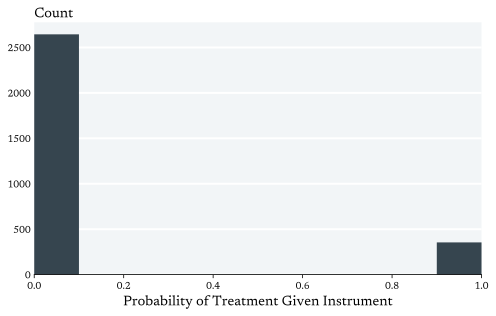

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Set Up Device**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [11]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig


quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_storage=torch.bfloat16,
)

lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)


#### **Tokenizer**

In [12]:
model_id = "meta-llama/Meta-Llama-3-8B" #"microsoft/phi-3-mini-4k-instruct" #
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

def tokenizer_function(example):
  return tokenizer(example["FullDescription"], truncation=True, max_length=512)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
df = df.rename(columns={'Treatment': 'label'})
df_treated = df.copy()
df_treated.pop('FullDescription')
df_control = df.copy()
df_control.pop('FullDescription')
df_treated = df_treated.rename(columns={'Treated_FullDescription': 'FullDescription'})
df_control = df_control.rename(columns={'Control_FullDescription': 'FullDescription'})

original_dataset = Dataset.from_dict(df[['FullDescription','label']])
treated_dataset = Dataset.from_dict(df_treated[['FullDescription','label']])
control_dataset = Dataset.from_dict(df_control[['FullDescription','label']])

tokenized_dataset = original_dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['FullDescription'])

tokenized_treated_dataset = treated_dataset.map(tokenizer_function, batched=True)
tokenized_treated_dataset = tokenized_treated_dataset.remove_columns(['FullDescription'])

tokenized_control_dataset = control_dataset.map(tokenizer_function, batched=True)
tokenized_control_dataset = tokenized_control_dataset.remove_columns(['FullDescription'])

tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=0.5, seed=42)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

#### **DataLoaders**

In [14]:
treated_loader = DataLoader(tokenized_treated_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
control_loader = DataLoader(tokenized_control_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
train_loader = DataLoader(tokenized_dataset_split['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset_split['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Model**

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           device_map='auto',
                                                           quantization_config=quantization_config,
                                                           num_labels=2, 
                                                           torch_dtype=torch.bfloat16,
                                                           trust_remote_code=True)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 13,639,680 || all params: 7,518,572,544 || trainable%: 0.1814131594817794
None


#### **Optimizer and Scheduler**

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Class Weights**

In [18]:
class_weights = torch.tensor([1., 1.], device=device) 
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output')

#### **Trainer**

In [19]:
yuri = EncoderTrainer(model, optimizer, scheduler, compute_recall, criterion, device, False)
early_stopping = EarlyStopping(patience)

In [25]:
# Compute Initial Train/Validation Losses
evaluation_losses = [yuri.evaluate(test_loader)]
training_losses =  [yuri.evaluate(train_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')

# Initialize Empty Lists to Store Recall and Learning Rate Histories
metric_history = []
learning_rate_history = []

for epoch in pbar:

    train_loss, (recall, _), current_lr = yuri.train(train_loader)

    training_losses.append(train_loss)
    metric_history.append(recall)
    learning_rate_history.append(current_lr)
    
    val_loss = yuri.evaluate(test_loader)
    evaluation_losses.append(val_loss)

    # Update the progress bar description for the current epoch
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    
    # Call early stopping
    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 7, Train Loss: 0.0015, Val Loss: 0.0049:  23%|██▎       | 7/30 [18:27<1:00:38, 158.19s/it]


KeyboardInterrupt: 

#### **Plot Loss History**

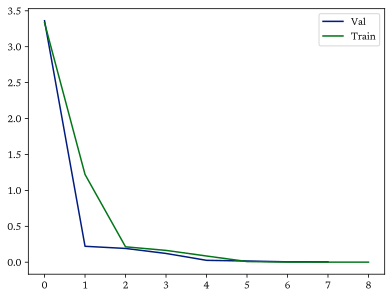

In [26]:
plt.plot(evaluation_losses, label='Val')
plt.plot(training_losses, label='Train')
plt.legend()
plt.show()

#### **Entire Data Set Predictions**

In [27]:
Dhat , labels = predict(model, all_loader, device)

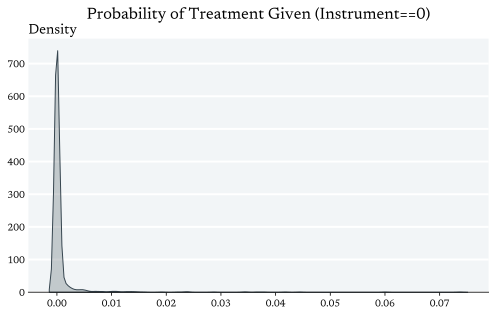

In [28]:
if verbose:# Create figure and axes with specific settings
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.set_title('Probability of Treatment Given (Instrument==0)', size=16, pad=20)

    # Set visibility of some spines
    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    # Add text to the axes
    ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

    # Set Y-axis tick parameters and grid
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    # Plot the KDE plot
    sns.kdeplot(Dhat[df['Instrument']==0], color='#36454F', fill=True, bw_adjust=0.5)
    plt.ylabel('')
    plt.show()

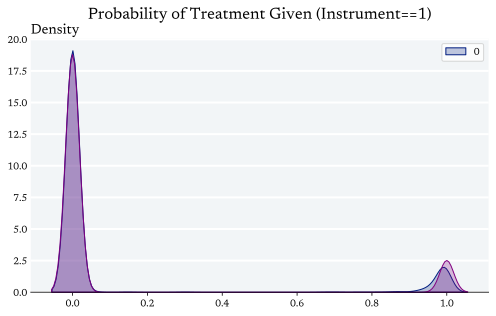

In [33]:
if verbose:
    # Create figure and axes with specific settings
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.set_title('Probability of Treatment Given (Instrument==1)', size=16, pad=20)

    # Set visibility of some spines
    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    # Add text to the axes
    ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

    # Set Y-axis tick parameters and grid
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    # Plot the KDE plot
    sns.kdeplot(Dhat[df['Instrument']==1], color='#36454F', fill=True, bw_adjust=0.25)
    sns.kdeplot(df['FStage_Value'][df['Instrument']==1], color='purple', fill=True, bw_adjust=0.25)
    plt.ylabel('')
    plt.xlabel('')
    plt.show()

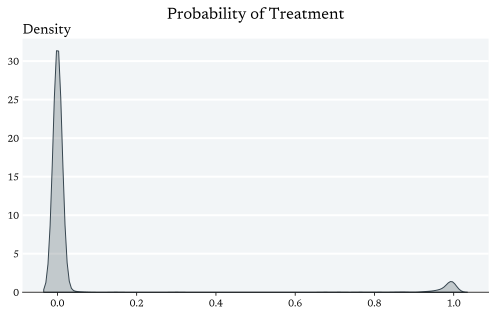

In [30]:
if verbose:
    # Create figure and axes with specific settings
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.set_title('Probability of Treatment', size=16, pad=20)

    # Set visibility of some spines
    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    # Add text to the axes
    ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

    # Set Y-axis tick parameters and grid
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    # Plot the KDE plot
    sns.kdeplot(Dhat, color='#36454F', fill=True, bw_adjust=0.25)
    #sns.kdeplot(df['FStage_Value']*df['label'], color='purple', fill=True, bw_adjust=0.25)
    plt.ylabel('')
    plt.show()

#### **Save Results**

In [32]:
# Assuming df is your DataFrame and Dhat is already defined in your context
Dhat, _ = predict(model, all_loader, device)
Dhat = Dhat.reshape(-1,1)
Dhat1, _ = predict(model, treated_loader, device)
Dhat1 = Dhat1.reshape(-1,1)
Dhat0, _ = predict(model, control_loader, device)
Dhat0 = Dhat0.reshape(-1,1)
expected_value = (0.5*Dhat1 + 0.5*Dhat0)
residuals = Dhat - expected_value
y = np.array(df['Outcome'].values.reshape(-1,1))
est = np.linalg.lstsq(np.hstack((residuals, np.ones_like(residuals))), y)[0][0]

df_result = pd.DataFrame({'Estimate': est})

# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/llms_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_result[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_result[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)

est

array([1.01107025])

In [ ]:
residuals = Dhat - expected_value
idx = np.abs(residuals) > 0.001
y = np.array(df['Outcome'].values.reshape(-1,1))
residuals_aug = residuals[idx].reshape(-1,1)
y_aug = y[idx].reshape(-1,1)

est = np.linalg.lstsq(np.hstack((residuals_aug, np.ones_like(residuals_aug))), y_aug)[0][0]
est

In [ ]:
D = np.array(df['label'].values.reshape(-1,1)) 
Z = np.array(df['Instrument'].values.reshape(-1,1))
Y = np.array(df['Outcome'].values.reshape(-1,1))

regs = np.hstack((np.ones_like(Z), Z))
Dhat_xz = regs @ np.linalg.lstsq(regs, D)[0]
 
regs = np.ones_like(Z)
Dhat_x = np.array(regs @ np.linalg.lstsq(regs, D)[0])

residuals = Dhat_xz - Dhat_x
np.linalg.lstsq(np.hstack((residuals, np.ones_like(residuals))), Y)


plt.hist(residuals);

In [ ]:
X = np.array(df[['Fault']].values).reshape(-1,1)
D = np.array(df['label'].values.reshape(-1,1)) 
Z = np.array(df['Instrument'].values.reshape(-1,1))
Y = np.array(df['Outcome'].values.reshape(-1,1))

regs = np.hstack((np.ones_like(X), X, Z, Z*X))
Dhat_xz = regs @ np.linalg.lstsq(regs, D)[0]
 
regs = np.hstack((np.ones_like(X), X))
Dhat_x = np.array(regs @ np.linalg.lstsq(regs, D)[0])

residuals = Dhat_xz - Dhat_x
np.linalg.lstsq(np.hstack((residuals, np.ones_like(residuals))), Y)

In [ ]:
plt.hist(Dhat_train);

In [ ]:
plt.hist(Dhat_test);

In [ ]:
(Dhat1 < 0.95).shape

In [ ]:
idx2 = ((df['Fault']==0).values) & (Dhat1 < 0.8).reshape(-1,)
idx3 =  ((df['Fault']==0).values) & (Dhat1 > 0.95).reshape(-1,)

In [ ]:
to_markdown(df['Description'][idx2].iloc[0])

In [ ]:
Dhat1[idx2][0]

In [ ]:
to_markdown(df['Description'][idx3].iloc[0])

In [ ]:
Dhat1[idx3][0]

In [ ]:
plt.hist(Dhat1[df['Fault']==0])
plt.show()

In [ ]:
plt.hist(Dhat1[df['Fault']==1], bins=10)
plt.xlim(0, 1)
plt.show()

In [ ]:
plt.hist(residuals)

In [ ]:

plt.hist(Dhat1[df['Fault']==1], bins=10)
plt.xlim(0, 1)
plt.show()

In [ ]:
plt.hist(Dhat_x[df['Fault']==0])
plt.xlim(0, 1)
plt.show()
plt.hist(Dhat_x[df['Fault']==1])
plt.xlim(0, 1)
plt.show()

In [ ]:
plt.scatter(Dhat_xz, Dhat, alpha=0.1)
plt.plot([-1,1], [-1,1])
plt.show()